# Sunbird RC API - Filter Exploration & Visualization

This notebook explores the Elasticsearch-based filter capabilities of the Sunbird RC Registry API
and provides visualizations of Water Facility data from Liberia WPM 2017.

## Features
- Automatic token refresh when expired
- Elasticsearch query filter exploration
- Data visualizations (charts, maps)

## API Filter Reference (Elasticsearch-based)
The search API accepts filters in JSON format that map to Elasticsearch queries:
- `{"field": {"eq": "value"}}` - Exact match
- `{"field": {"neq": "value"}}` - Not equal
- `{"field": {"gt": value}}` - Greater than
- `{"field": {"gte": value}}` - Greater than or equal
- `{"field": {"lt": value}}` - Less than
- `{"field": {"lte": value}}` - Less than or equal
- `{"field": {"contains": "text"}}` - Text contains
- `{"field": {"or": ["val1", "val2"]}}` - Match any in array
- `{"field.nested": {"eq": "value"}}` - Nested object query

In [1]:
import requests
import json
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from getpass import getpass
from datetime import datetime
from IPython.display import display, Markdown, JSON

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Configuration
DOMAIN = "https://sunbird-rc.akvotest.org"
BASE_URL = f"{DOMAIN}/api/v1"
KEYCLOAK_URL = f"{DOMAIN}/auth/realms/sunbird-rc/protocol/openid-connect/token"

# Auth credentials
CLIENT_ID = "demo-api"
CLIENT_SECRET = os.environ.get("SUNBIRD_DEMO_API_CLIENT_SECRET") or getpass("Enter demo-api client secret: ")

print(f"Registry API: {BASE_URL}")
print(f"Keycloak Token URL: {KEYCLOAK_URL}")

/home/dedenbangkit/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Registry API: https://sunbird-rc.akvotest.org/api/v1
Keycloak Token URL: https://sunbird-rc.akvotest.org/auth/realms/sunbird-rc/protocol/openid-connect/token


## Token Management with Auto-Refresh

The `TokenManager` class handles authentication and automatic token refresh when expired.

In [2]:
class TokenManager:
    """Manages OAuth2 tokens with automatic refresh."""
    
    def __init__(self, keycloak_url, client_id, client_secret):
        self.keycloak_url = keycloak_url
        self.client_id = client_id
        self.client_secret = client_secret
        self.access_token = None
        self.expires_at = 0
        self.refresh_buffer = 30  # Refresh 30 seconds before expiry
    
    def _fetch_token(self):
        """Fetch a new token from Keycloak."""
        response = requests.post(self.keycloak_url, data={
            "client_id": self.client_id,
            "client_secret": self.client_secret,
            "grant_type": "client_credentials"
        })
        
        if response.status_code == 200:
            data = response.json()
            self.access_token = data["access_token"]
            self.expires_at = time.time() + data["expires_in"] - self.refresh_buffer
            return True
        else:
            print(f"Token fetch failed: {response.status_code}")
            print(response.text)
            return False
    
    def is_expired(self):
        """Check if token is expired or will expire soon."""
        return self.access_token is None or time.time() >= self.expires_at
    
    def get_token(self):
        """Get a valid token, refreshing if necessary."""
        if self.is_expired():
            print(f"[{datetime.now().strftime('%H:%M:%S')}] Refreshing token...")
            if not self._fetch_token():
                raise Exception("Failed to obtain access token")
            print(f"[{datetime.now().strftime('%H:%M:%S')}] Token refreshed (expires at {datetime.fromtimestamp(self.expires_at).strftime('%H:%M:%S')})")
        return self.access_token
    
    def get_headers(self):
        """Get auth headers with a valid token."""
        return {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {self.get_token()}"
        }
    
    def time_until_expiry(self):
        """Return seconds until token expires."""
        if self.access_token is None:
            return 0
        return max(0, self.expires_at - time.time())

# Initialize token manager
token_manager = TokenManager(KEYCLOAK_URL, CLIENT_ID, CLIENT_SECRET)

# Test initial token fetch
_ = token_manager.get_token()
print(f"Token valid for {token_manager.time_until_expiry():.0f} seconds")

[19:43:00] Refreshing token...
[19:43:01] Token refreshed (expires at 19:47:31)
Token valid for 270 seconds


## API Helper Functions

In [3]:
def search_facilities(filters=None, limit=100, offset=0, fields=None, measure_time=False):
    """
    Search water facilities with filters.

    Args:
        filters: Dict of filter conditions (Elasticsearch query format)
        limit: Max records to return
        offset: Number of records to skip
        fields: List of fields to return (None for all) - may not be supported by all APIs
        measure_time: If True, include response time in result

    Returns:
        Dict with 'data', 'totalCount', 'offset', and optionally 'response_time_sec'
    """
    payload = {
        "filters": filters or {},
        "limit": limit,
        "offset": offset
    }
    if fields:
        payload["fields"] = fields

    start_time = time.time()
    response = requests.post(
        f"{BASE_URL}/WaterFacility/search",
        headers=token_manager.get_headers(),
        json=payload
    )
    elapsed_time = time.time() - start_time

    if response.status_code == 200:
        result = response.json()
        if measure_time:
            result['response_time_sec'] = round(elapsed_time, 3)
        return result
    else:
        print(f"Search failed: {response.status_code}")
        print(response.text)
        return None


def get_all_facilities(filters=None, fields=None, batch_size=500, max_records=None, measure_time=False):
    """
    Fetch all facilities matching filters with pagination.

    Args:
        filters: Dict of filter conditions
        fields: List of fields to return (None for all)
        batch_size: Records per request
        max_records: Max total records (None for all)
        measure_time: If True, track total fetch time

    Returns:
        Tuple of (data_list, timing_info) if measure_time else data_list
    """
    all_data = []
    offset = 0
    total_time = 0

    # Get first batch to know total count
    start = time.time()
    result = search_facilities(filters=filters, fields=fields, limit=batch_size, offset=0)
    total_time += time.time() - start

    if not result:
        return ([], {'total_time_sec': 0, 'requests': 0}) if measure_time else []

    # Handle different response formats
    data_key = 'data' if 'data' in result else None
    if not data_key:
        # If no 'data' key, the result might be a list directly or have different structure
        print(f"Warning: Unexpected response format. Keys: {result.keys()}")
        return ([], {'total_time_sec': 0, 'requests': 0}) if measure_time else []

    total_count = result.get('totalCount', len(result[data_key]))
    all_data.extend(result[data_key])
    offset += len(result[data_key])
    request_count = 1

    target_count = min(total_count, max_records) if max_records else total_count
    print(f"Fetching {target_count} of {total_count} records...")

    while offset < target_count:
        start = time.time()
        result = search_facilities(filters=filters, fields=fields, limit=batch_size, offset=offset)
        total_time += time.time() - start
        request_count += 1

        if not result or data_key not in result or not result[data_key]:
            break
        all_data.extend(result[data_key])
        offset += len(result[data_key])
        print(f"  Fetched {offset}/{target_count}", end='\r')

    print(f"  Fetched {len(all_data)} records total")

    if measure_time:
        timing = {
            'total_time_sec': round(total_time, 3),
            'requests': request_count,
            'avg_time_per_request': round(total_time / request_count, 3) if request_count > 0 else 0,
            'records_per_sec': round(len(all_data) / total_time, 1) if total_time > 0 else 0
        }
        return all_data, timing

    return all_data


def to_dataframe(data):
    """Convert API response data to a flattened DataFrame."""
    if not data:
        return pd.DataFrame()

    df = pd.DataFrame(data)

    # Flatten location object if present
    if 'location' in df.columns:
        location_df = pd.json_normalize(df['location'])
        location_df.columns = [f'location_{col}' for col in location_df.columns]
        df = pd.concat([df.drop('location', axis=1), location_df], axis=1)

    return df

## 1. Basic Statistics

In [4]:
# Get total count
result = search_facilities(filters={}, limit=1)
total_facilities = result['totalCount'] if result else 0
print(f"Total Water Facilities in Registry: {total_facilities:,}")

Total Water Facilities in Registry: 19,210


## 1.1 Performance Measurement

Measure API response times to understand performance characteristics.

In [5]:
# Measure API response time for different query sizes
print("Performance Benchmark: Query Response Times")
print("=" * 60)

limits = [10, 50, 100, 500, 1000]
perf_results = []

for limit in limits:
    result = search_facilities(filters={}, limit=limit, measure_time=True)
    if result:
        perf_results.append({
            'limit': limit,
            'records': len(result['data']),
            'time_sec': result['response_time_sec'],
            'records_per_sec': round(len(result['data']) / result['response_time_sec'], 1) if result['response_time_sec'] > 0 else 0
        })
        print(f"  Limit {limit:4d}: {result['response_time_sec']:.3f}s ({len(result['data'])} records)")

print("\n" + "=" * 60)
df_perf = pd.DataFrame(perf_results)
display(df_perf)

Performance Benchmark: Query Response Times
  Limit   10: 0.374s (10 records)
  Limit   50: 0.545s (50 records)
  Limit  100: 1.002s (100 records)
  Limit  500: 1.798s (500 records)
  Limit 1000: 1.918s (1000 records)



,limit,records,time_sec,records_per_sec
0,10,10,0.374,26.7
1,50,50,0.545,91.7
2,100,100,1.002,99.8
3,500,500,1.798,278.1
4,1000,1000,1.918,521.4


## 1.2 Field Filtering

Use the `fields` parameter to return only specific fields, reducing payload size and potentially improving performance.

**Available fields:** `wfId`, `geoCode`, `waterPointType`, `location`, `extractionType`, `pumpType`, `numTaps`, `hasDepthInfo`, `depthMetres`, `installer`, `owner`, `funder`, `photoUrl`, `osid`, `osCreatedAt`, etc.

In [6]:
# Example: Fetch only specific fields
selected_fields = ["wfId", "geoCode", "waterPointType", "location"]

result = search_facilities(
    filters={"location.county": {"eq": "Nimba"}},
    limit=5,
    fields=selected_fields,
    measure_time=True
)

print(f"Query with fields={selected_fields}")
print(f"Response time: {result['response_time_sec']:.3f}s")
print(f"Total matching: {result['totalCount']}")
print("\nReturned data (only selected fields):")
display(JSON(result['data'][0], expanded=True))

Query with fields=['wfId', 'geoCode', 'waterPointType', 'location']
Response time: 0.381s
Total matching: 2077

Returned data (only selected fields):


<IPython.core.display.JSON object>

## 1.3 Performance Comparison: All Fields vs Selected Fields

Compare response times when fetching all fields versus only necessary fields.

In [7]:
# Performance comparison: All fields vs Selected fields
print("Performance Comparison: All Fields vs Selected Fields")
print("=" * 60)

test_limits = [100, 500, 1000]
comparison_results = []

for limit in test_limits:
    # All fields
    result_all = search_facilities(filters={}, limit=limit, measure_time=True)
    time_all = result_all['response_time_sec'] if result_all else 0

    # Selected fields only
    result_selected = search_facilities(
        filters={},
        limit=limit,
        fields=["wfId", "geoCode", "waterPointType", "location"],
        measure_time=True
    )
    time_selected = result_selected['response_time_sec'] if result_selected else 0

    # Minimal fields
    result_minimal = search_facilities(
        filters={},
        limit=limit,
        fields=["wfId", "geoCode"],
        measure_time=True
    )
    time_minimal = result_minimal['response_time_sec'] if result_minimal else 0

    comparison_results.append({
        'limit': limit,
        'all_fields_sec': time_all,
        'selected_fields_sec': time_selected,
        'minimal_fields_sec': time_minimal,
        'speedup_selected': f"{(time_all / time_selected - 1) * 100:.1f}%" if time_selected > 0 else "N/A",
        'speedup_minimal': f"{(time_all / time_minimal - 1) * 100:.1f}%" if time_minimal > 0 else "N/A"
    })

    print(f"Limit {limit}:")
    print(f"  All fields:      {time_all:.3f}s")
    print(f"  Selected (4):    {time_selected:.3f}s")
    print(f"  Minimal (2):     {time_minimal:.3f}s")
    print()

print("=" * 60)
df_comparison = pd.DataFrame(comparison_results)
display(df_comparison)

Performance Comparison: All Fields vs Selected Fields
Limit 100:
  All fields:      0.760s
  Selected (4):    0.769s
  Minimal (2):     0.499s

Limit 500:
  All fields:      1.793s
  Selected (4):    1.561s
  Minimal (2):     1.553s

Limit 1000:
  All fields:      2.183s
  Selected (4):    1.632s
  Minimal (2):     1.935s



,limit,all_fields_sec,selected_fields_sec,minimal_fields_sec,speedup_selected,speedup_minimal
0,100,0.760,0.769,0.499,-1.2%,52.3%
1,500,1.793,1.561,1.553,14.9%,15.5%
2,1000,2.183,1.632,1.935,33.8%,12.8%


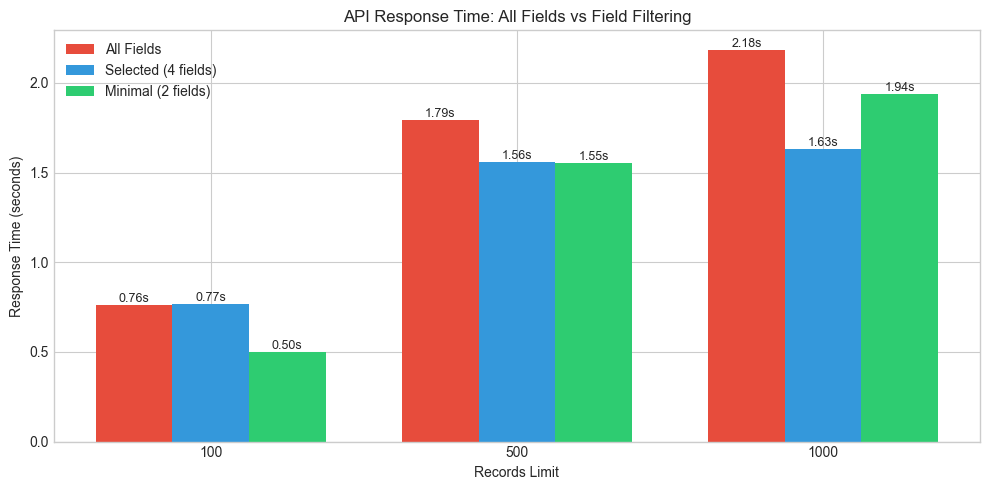

In [8]:
# Visualize performance comparison
fig, ax = plt.subplots(figsize=(10, 5))

x = range(len(test_limits))
width = 0.25

bars1 = ax.bar([i - width for i in x], df_comparison['all_fields_sec'], width, label='All Fields', color='#e74c3c')
bars2 = ax.bar([i for i in x], df_comparison['selected_fields_sec'], width, label='Selected (4 fields)', color='#3498db')
bars3 = ax.bar([i + width for i in x], df_comparison['minimal_fields_sec'], width, label='Minimal (2 fields)', color='#2ecc71')

ax.set_xlabel('Records Limit')
ax.set_ylabel('Response Time (seconds)')
ax.set_title('API Response Time: All Fields vs Field Filtering')
ax.set_xticks(x)
ax.set_xticklabels(test_limits)
ax.legend()

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 1.4 Filter Complexity Performance

Compare response times for different filter types and complexity levels.

In [9]:
# Benchmark different filter types
print("Filter Complexity Performance Benchmark")
print("=" * 60)

filter_tests = [
    ("No filter", {}),
    ("Single eq", {"location.county": {"eq": "Nimba"}}),
    ("Single contains", {"location.community": {"contains": "Town"}}),
    ("OR filter (3 values)", {"location.county": {"or": ["Nimba", "Bong", "Lofa"]}}),
    ("Range filter", {"location.coordinates.elevation": {"gte": 200, "lte": 400}}),
    ("Combined (2 filters)", {
        "location.county": {"eq": "Nimba"},
        "waterPointType": {"eq": "Tube well or borehole"}
    }),
    ("Combined (3 filters)", {
        "location.county": {"eq": "Nimba"},
        "waterPointType": {"eq": "Tube well or borehole"},
        "installer": {"eq": "Government"}
    }),
    ("Complex (4 filters)", {
        "waterPointType": {"or": ["Tube well or borehole", "Protected spring"]},
        "extractionType": {"eq": "Electrical"},
        "location.coordinates.elevation": {"gt": 300},
        "owner": {"neq": "Unknown"}
    }),
]

filter_perf = []
for name, filters in filter_tests:
    result = search_facilities(filters=filters, limit=100, measure_time=True)
    if result:
        filter_perf.append({
            'filter_type': name,
            'matches': result['totalCount'],
            'time_sec': result['response_time_sec']
        })
        print(f"  {name:25s}: {result['response_time_sec']:.3f}s ({result['totalCount']:,} matches)")

print("\n" + "=" * 60)
df_filter_perf = pd.DataFrame(filter_perf)
display(df_filter_perf)

Filter Complexity Performance Benchmark
  No filter                : 0.997s (19,210 matches)
  Single eq                : 1.029s (2,077 matches)
  Single contains          : 1.085s (3,770 matches)
  OR filter (3 values)     : 1.013s (4,903 matches)
  Range filter             : 1.026s (6,032 matches)
  Combined (2 filters)     : 1.028s (187 matches)
  Combined (3 filters)     : 0.376s (7 matches)
  Complex (4 filters)      : 0.753s (137 matches)



,filter_type,matches,time_sec
0,No filter,19210,0.997
1,Single eq,2077,1.029
2,Single contains,3770,1.085
3,OR filter (3 values),4903,1.013
4,Range filter,6032,1.026
5,Combined (2 filters),187,1.028
6,Combined (3 filters),7,0.376
7,Complex (4 filters),137,0.753


In [10]:
# Full Dataset Fetch Performance Test
# Note: Elasticsearch has a default limit of 10,000 records (max_result_window)
# To fetch all data, we need to use filters to partition the data

print("Full Dataset Fetch Performance Test")
print("=" * 60)

# Get total count
result = search_facilities(filters={}, limit=1, measure_time=True)
total_count = result['totalCount']
print(f"Total records in registry: {total_count:,}")

# Test fields parameter support
test_with_fields = search_facilities(filters={}, limit=2, fields=["location", "waterPointType"])
sample_all = search_facilities(filters={}, limit=1)
fields_in_all = len(sample_all['data'][0].keys()) if sample_all and 'data' in sample_all else 0
fields_in_filtered = len(test_with_fields['data'][0].keys()) if test_with_fields and 'data' in test_with_fields else 0
print(f"\nFields parameter supported: {fields_in_filtered < fields_in_all}")
print(f"  All fields: {fields_in_all} keys")
print(f"  With fields param: {fields_in_filtered} keys")

print("-" * 60)

# Try to fetch with offset > 10000 to confirm the limit
print("\nTesting Elasticsearch pagination limit...")
test_offset = search_facilities(filters={}, limit=1, offset=9999)
print(f"  Offset 9999: {'OK' if test_offset and 'data' in test_offset else 'FAILED'}")

test_offset_over = search_facilities(filters={}, limit=1, offset=10000)
print(f"  Offset 10000: {'OK' if test_offset_over and 'data' in test_offset_over else 'FAILED (ES limit)'}")

# Fetch up to the limit
print(f"\nFetching records (up to ES limit of 10,000)...")
data_all, timing_all = get_all_facilities(
    filters={},
    batch_size=1000,
    max_records=10000,  # Respect ES limit
    measure_time=True
)

print()
print("=" * 60)
print("RESULTS: Dataset Fetch (up to 10K limit)")
print("=" * 60)
print(f"Total records fetched: {len(data_all):,}")
print(f"Total time: {timing_all['total_time_sec']:.2f} seconds")
print(f"Number of API requests: {timing_all['requests']}")
print(f"Avg time per request: {timing_all['avg_time_per_request']:.3f}s")
print(f"Throughput: {timing_all['records_per_sec']:.1f} records/sec")
print()
print(f"Note: Elasticsearch default max_result_window is 10,000")
print(f"To fetch all {total_count:,} records, use filter partitioning (see next cell)")

Full Dataset Fetch Performance Test
Total records in registry: 19,210

Fields parameter supported: False
  All fields: 16 keys
  With fields param: 16 keys
------------------------------------------------------------

Testing Elasticsearch pagination limit...
  Offset 9999: OK
  Offset 10000: FAILED (ES limit)

Fetching records (up to ES limit of 10,000)...
Fetching 10000 of 19210 records...
  Fetched 10000 records total

RESULTS: Dataset Fetch (up to 10K limit)
Total records fetched: 10,000
Total time: 19.37 seconds
Number of API requests: 10
Avg time per request: 1.937s
Throughput: 516.3 records/sec

Note: Elasticsearch default max_result_window is 10,000
To fetch all 19,210 records, use filter partitioning (see next cell)


In [11]:
# Fetch ALL data by partitioning by county (to bypass 10K limit)
print("Fetching ALL data by partitioning by county")
print("=" * 60)

# First, get list of counties and their counts
counties_data = {}
sample = get_all_facilities(filters={}, batch_size=1000, max_records=5000)
df_sample = to_dataframe(sample)
county_list = df_sample['location_county'].unique().tolist()

print(f"Found {len(county_list)} counties")

# Fetch data for each county
all_data_partitioned = []
partition_timing = {'total_time': 0, 'requests': 0}

start_total = time.time()
for county in county_list:
    data, timing = get_all_facilities(
        filters={"location.county": {"eq": county}},
        batch_size=1000,
        max_records=None,  # Get all for this county
        measure_time=True
    )
    all_data_partitioned.extend(data)
    partition_timing['total_time'] += timing['total_time_sec']
    partition_timing['requests'] += timing['requests']
    print(f"  {county}: {len(data):,} records")

total_elapsed = time.time() - start_total

print()
print("=" * 60)
print("RESULTS: Full Dataset via Partitioning")
print("=" * 60)
print(f"Total records fetched: {len(all_data_partitioned):,}")
print(f"Total time: {total_elapsed:.2f} seconds")
print(f"Number of API requests: {partition_timing['requests']}")
print(f"Throughput: {len(all_data_partitioned) / total_elapsed:.1f} records/sec")

# Use this as our full dataset
data_all = all_data_partitioned
timing_all = {
    'total_time_sec': total_elapsed,
    'requests': partition_timing['requests'],
    'records_per_sec': len(all_data_partitioned) / total_elapsed
}

Fetching ALL data by partitioning by county
Fetching 5000 of 19210 records...
  Fetched 5000 records total
Found 15 counties
Fetching 5917 of 5917 records...
  Fetched 5917 records total
  Montserrado: 5,917 records
Fetching 2077 of 2077 records...
  Fetched 2077 records total
  Nimba: 2,077 records
Fetching 1275 of 1275 records...
  Fetched 1275 records total
  Bomi: 1,275 records
Fetching 1453 of 1453 records...
  Fetched 1453 records total
  Lofa: 1,453 records
Fetching 729 of 729 records...
  Fetched 729 records total
  Grand Cape Mount: 729 records
Fetching 1151 of 1151 records...
  Fetched 1151 records total
  Grand Bassa: 1,151 records
Fetching 1373 of 1373 records...
  Fetched 1373 records total
  Bong: 1,373 records
Fetching 413 of 413 records...
  Fetched 413 records total
  Grand Kru: 413 records
Fetching 635 of 635 records...
  Fetched 635 records total
  Maryland: 635 records
Fetching 909 of 909 records...
  Fetched 909 records total
  Grand Gedeh: 909 records
Fetching 159

In [12]:
# Extract coordinates and indicator for visualization
print("Extracting minimal data for visualization...")
print("=" * 60)

if 'data_all' not in dir() or len(data_all) == 0:
    print("ERROR: No data available. Run the previous cell first to fetch data.")
else:
    df_map = to_dataframe(data_all)
    
    # Show available columns
    print(f"Total records: {len(df_map):,}")
    print(f"Available columns: {len(df_map.columns)}")
    
    # Extract only what we need: lat, lon, waterPointType
    required_cols = ['location_coordinates.lat', 'location_coordinates.lon', 'waterPointType']
    available_cols = [c for c in required_cols if c in df_map.columns]
    
    if len(available_cols) == 3:
        df_minimal = df_map[available_cols].copy()
        df_minimal = df_minimal.dropna()
        
        print(f"\nExtracted minimal data:")
        print(f"  Records with valid coordinates: {len(df_minimal):,}")
        print(f"  Memory usage: {df_minimal.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
        print(f"\nWater Point Type distribution:")
        print(df_minimal['waterPointType'].value_counts())
    else:
        print(f"ERROR: Missing columns: {set(required_cols) - set(available_cols)}")
        print(f"Available columns: {list(df_map.columns)}")

Extracting minimal data for visualization...
Total records: 19,209
Available columns: 41

Extracted minimal data:
  Records with valid coordinates: 19,209
  Memory usage: 1.69 MB

Water Point Type distribution:
waterPointType
Protected dug well                               10662
Unprotected dug well                              3986
Tube well or borehole                             1788
Protected spring                                  1062
Unprotected spring                                 579
Piped water into dwelling/plot/yard                432
Public tap/standpipe                               262
Other                                              180
Unequipped borehole                                118
Rainwater (harvesting)                              84
Sand/Sub-surface dam (with well or standpipe)       56
Name: count, dtype: int64


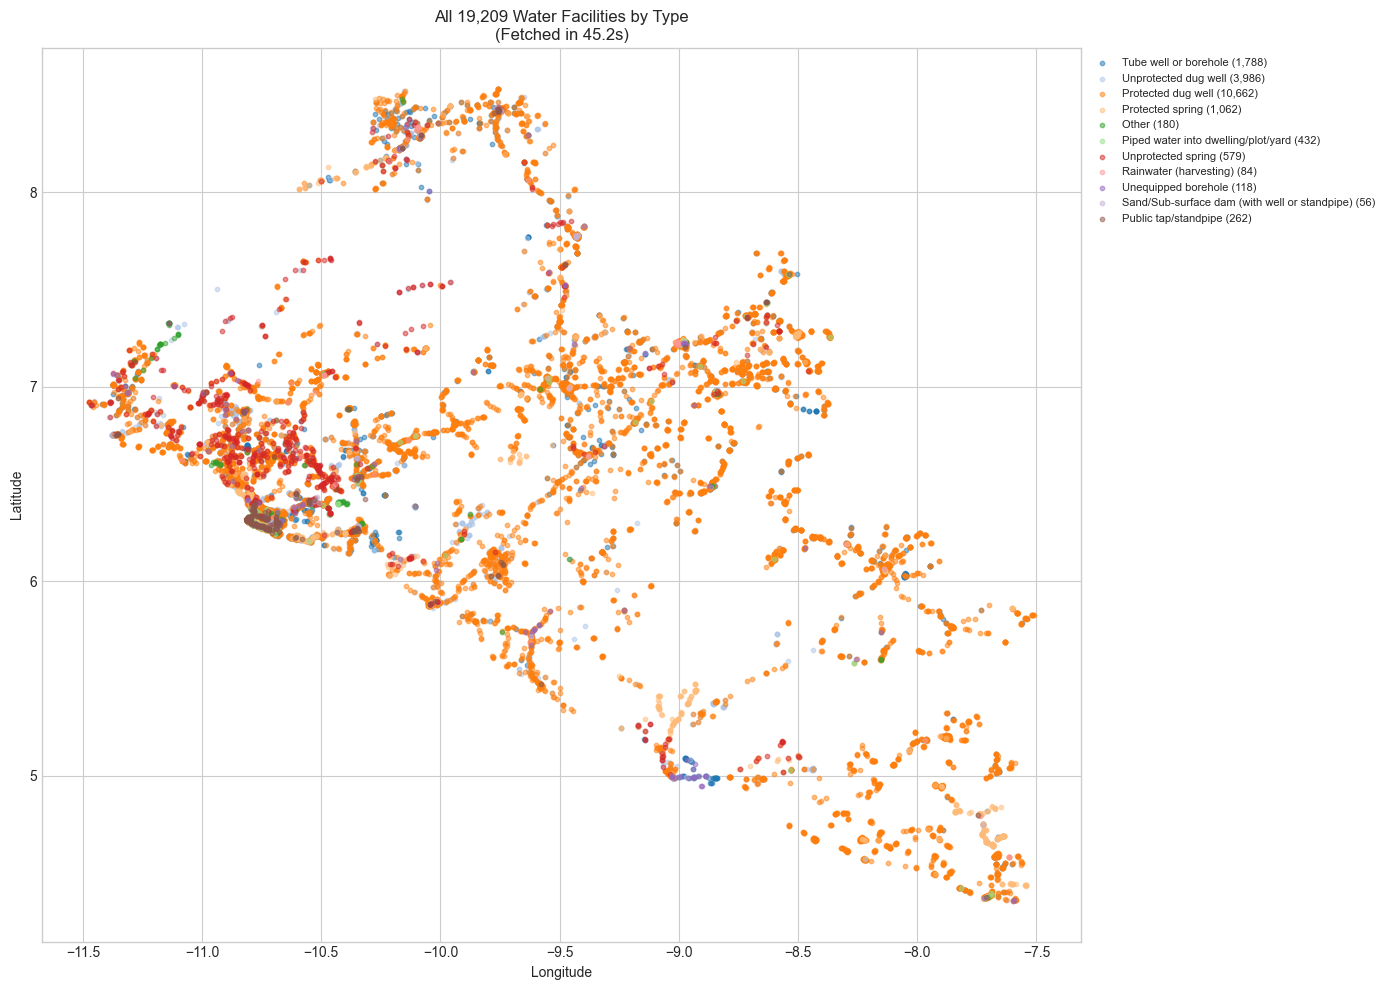


Visualization complete: 19,209 water points plotted


In [13]:
# Visualize all data on a map
if 'df_minimal' not in dir():
    print("ERROR: df_minimal not defined. Run the previous cell first.")
elif len(df_minimal) == 0:
    print("ERROR: df_minimal is empty. Check data extraction.")
else:
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Color by water point type - use tab20 for more colors
    water_types = df_minimal['waterPointType'].unique()
    n_types = len(water_types)
    
    # Use tab20 colormap which has 20 colors, or cycle if more needed
    if n_types <= 20:
        color_list = plt.cm.tab20.colors[:n_types]
    else:
        color_list = [plt.cm.tab20(i % 20) for i in range(n_types)]
    
    colors = dict(zip(water_types, color_list))
    
    for wtype in water_types:
        subset = df_minimal[df_minimal['waterPointType'] == wtype]
        ax.scatter(
            subset['location_coordinates.lon'],
            subset['location_coordinates.lat'],
            c=[colors[wtype]],
            label=f"{wtype} ({len(subset):,})",
            alpha=0.5,
            s=10
        )
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'All {len(df_minimal):,} Water Facilities by Type\n(Fetched in {timing_all["total_time_sec"]:.1f}s)')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualization complete: {len(df_minimal):,} water points plotted")

## 2. Filter Exploration

### 2.1 Equality Filter (`eq`)
Find facilities with exact field match.

In [14]:
# Filter by exact county
result = search_facilities(
    filters={"location.county": {"eq": "Nimba"}},
    limit=5
)

print(f"Facilities in Nimba county: {result['totalCount']}")
print("\nSample records:")
df_sample = to_dataframe(result['data'])
display(df_sample[['wfId', 'geoCode', 'waterPointType', 'location_county', 'location_district']].head())

Facilities in Nimba county: 2077

Sample records:


,wfId,geoCode,waterPointType,location_county,location_district
0,WF-NIM-SAN-PDW-473C97,xvksf3s,Protected dug well,Nimba,Sanniquellie Mahn
1,WF-NIM-MEI-PDW-64D7BA,x33ocy0,Protected dug well,Nimba,Meinpea-Mahn
2,WF-NIM-ZOE-PDW-9D315F,woqtv8c,Protected dug well,Nimba,Zoe Gbao
3,WF-NIM-DOE-PDW-45250B,tvn6tj3,Protected dug well,Nimba,Doe
4,WF-NIM-GAR-UEB-90E9F2,x6648pv,Unequipped borehole,Nimba,Garr-Bain


### 2.2 OR Filter - Multiple Values
Match any value from a list.

In [15]:
# Filter by multiple counties
counties = ["Nimba", "Bong", "Grand Gedeh"]
result = search_facilities(
    filters={"location.county": {"or": counties}},
    limit=10
)

print(f"Facilities in {counties}: {result['totalCount']}")
df = to_dataframe(result['data'])
print("\nCounty distribution in sample:")
display(df['location_county'].value_counts())

Facilities in ['Nimba', 'Bong', 'Grand Gedeh']: 4359

County distribution in sample:


location_county
Nimba    7
Bong     3
Name: count, dtype: int64

### 2.3 Comparison Filters (`gt`, `gte`, `lt`, `lte`)
Filter by numeric comparisons.

In [16]:
# Investigate depth data issue
# Source CSV has 3,562 records with has_depth_info="Yes" and 706 with depth > 50m
# But API returns 0 for hasDepthInfo=True - let's investigate

result = search_facilities(filters={}, limit=5)
sample = result['data'][0] if result and result['data'] else {}

print("All fields in a sample record:")
print("=" * 50)
for key, value in sorted(sample.items()):
    print(f"  {key}: {value} ({type(value).__name__})")

print("\n" + "=" * 50)
print("Checking depth-related fields:")

# Check if hasDepthInfo exists and what values it has
df_check = to_dataframe(result['data'])
if 'hasDepthInfo' in df_check.columns:
    print(f"\nhasDepthInfo values: {df_check['hasDepthInfo'].unique()}")
    print(f"hasDepthInfo dtype: {df_check['hasDepthInfo'].dtype}")
else:
    print("\n'hasDepthInfo' field NOT FOUND in response")
    
if 'depthMetres' in df_check.columns:
    print(f"\ndepthMetres values: {df_check['depthMetres'].unique()}")
else:
    print("'depthMetres' field NOT FOUND in response")

# Try different filter approaches
print("\n" + "=" * 50)
print("Testing different filter approaches:")

# Try with string "true" 
r1 = search_facilities(filters={"hasDepthInfo": {"eq": "true"}}, limit=1)
print(f"  hasDepthInfo='true' (string): {r1['totalCount'] if r1 else 'Error'}")

# Try with boolean True
r2 = search_facilities(filters={"hasDepthInfo": {"eq": True}}, limit=1)
print(f"  hasDepthInfo=True (bool): {r2['totalCount'] if r2 else 'Error'}")

# Try depthMetres directly
r3 = search_facilities(filters={"depthMetres": {"gt": 0}}, limit=1)
print(f"  depthMetres > 0: {r3['totalCount'] if r3 else 'Error'}")

All fields in a sample record:
  extractionType: Manual (str)
  geoCode: 82gq261p (str)
  hasDepthInfo: False (bool)
  installer: Private (str)
  location: {'county': 'Montserrado', 'district': 'Greater Monrovia', 'community': 'Kesselly Boulevard', 'coordinates': {'lat': 6.32278819, 'lon': -10.74212981, 'elevation': 25.3, 'osCreatedAt': '2026-02-17T14:29:01.146Z', 'osUpdatedAt': '2026-02-17T14:29:01.146Z', 'osCreatedBy': '24b898c0-0367-4bf1-ae07-daf2f9faa671', 'osUpdatedBy': '24b898c0-0367-4bf1-ae07-daf2f9faa671', 'osid': '1-ea307e04-2d40-4d83-b7b2-da9ed07a75ef'}, 'osCreatedAt': '2026-02-17T14:29:01.146Z', 'osUpdatedAt': '2026-02-17T14:29:01.146Z', 'osCreatedBy': '24b898c0-0367-4bf1-ae07-daf2f9faa671', 'osUpdatedBy': '24b898c0-0367-4bf1-ae07-daf2f9faa671', 'osid': '1-d355e1e3-b85d-463e-984f-0a296d769534'} (dict)
  osCreatedAt: 2026-02-17T14:29:01.146Z (str)
  osCreatedBy: 24b898c0-0367-4bf1-ae07-daf2f9faa671 (str)
  osOwner: ['24b898c0-0367-4bf1-ae07-daf2f9faa671'] (list)
  osUpdatedAt

### 2.4 Range Filter (Combined `gte` and `lte`)
Find facilities within a range.

In [17]:
# Find facilities at elevation between 200-400m
result = search_facilities(
    filters={
        "location.coordinates.elevation": {"gte": 200, "lte": 400}
    },
    limit=10
)

print(f"Facilities at elevation 200-400m: {result['totalCount']}")
df = to_dataframe(result['data'])
if not df.empty and 'location_coordinates.elevation' in df.columns:
    print(f"\nElevation range in sample: {df['location_coordinates.elevation'].min():.1f}m - {df['location_coordinates.elevation'].max():.1f}m")

Facilities at elevation 200-400m: 6032

Elevation range in sample: 245.0m - 543.7m


### 2.5 Contains Filter (Text Search)
Search for text within a field.

In [18]:
# Find facilities with "Town" in community name
result = search_facilities(
    filters={"location.community": {"contains": "Town"}},
    limit=10
)

print(f"Facilities with 'Town' in community name: {result['totalCount']}")
df = to_dataframe(result['data'])
if not df.empty:
    print("\nSample communities:")
    display(df[['wfId', 'location_community', 'location_county']].head())

Facilities with 'Town' in community name: 3770

Sample communities:


,wfId,location_community,location_county
0,WF-MON-GRE-PDW-35033D,Town,Montserrado
1,WF-MON-GRE-PDW-6F67AF,Via town/ napia town,Montserrado
2,WF-MAR-HAR-PDW-D1D80F,Middle Town new town,Maryland
3,WF-MAR-HAR-PDW-FECDCF,Middle Town mission Town,Maryland
4,WF-MAR-MAM-PS-36DC43,"Zorkpehs Town, Boyles Town",Margibi


### 2.6 Not Equal Filter (`neq`)
Exclude specific values.

In [19]:
# Find non-manual extraction facilities
result = search_facilities(
    filters={"extractionType": {"neq": "Manual"}},
    limit=10
)

print(f"Facilities with non-Manual extraction: {result['totalCount']}")
df = to_dataframe(result['data'])
if not df.empty and 'extractionType' in df.columns:
    print("\nExtraction types in sample:")
    display(df['extractionType'].value_counts())

Facilities with non-Manual extraction: 7069

Extraction types in sample:


extractionType
Other    1
Name: count, dtype: int64

### 2.7 Combined Filters (AND logic)
Multiple conditions combined with AND.

In [20]:
# Find borehole facilities in Nimba with Government installer
result = search_facilities(
    filters={
        "waterPointType": {"eq": "Tube well or borehole"},
        "location.county": {"eq": "Nimba"},
        "installer": {"eq": "Government"}
    },
    limit=10
)

print(f"Government-installed boreholes in Nimba: {result['totalCount']}")
df = to_dataframe(result['data'])
if not df.empty:
    display(df[['wfId', 'waterPointType', 'location_district', 'installer']].head())

Government-installed boreholes in Nimba: 7


,wfId,waterPointType,location_district,installer
0,WF-NIM-DOE-TWB-A9F589,Tube well or borehole,Doe,Government
1,WF-NIM-SAN-TWB-4DE1F8,Tube well or borehole,Sanniquellie Mahn,Government
2,WF-NIM-GAR-TWB-680E96,Tube well or borehole,Garr-Bain,Government
3,WF-NIM-BUU-TWB-1E5B56,Tube well or borehole,Buu-Yao,Government
4,WF-NIM-GAR-TWB-567D76,Tube well or borehole,Garr-Bain,Government


## 3. Data Visualizations

### 3.1 Aggregation by Water Point Type

In [21]:
# Get counts by water point type
water_point_types = [
    "Tube well or borehole",
    "Protected dug well",
    "Unprotected dug well",
    "Protected spring",
    "Unprotected spring",
    "Public tap/standpipe",
    "Rainwater (harvesting)",
    "Sand/Sub-surface dam (with well or standpipe)",
    "Piped water into dwelling/plot/yard",
    "Other"
]

type_counts = {}
for wpt in water_point_types:
    result = search_facilities(
        filters={"waterPointType": {"eq": wpt}},
        limit=1
    )
    if result:
        type_counts[wpt] = result['totalCount']
    print(f"  {wpt}: {result['totalCount'] if result else 0}", end='\r')

print("\n\nWater Point Type Distribution:")
for wpt, count in sorted(type_counts.items(), key=lambda x: -x[1]):
    print(f"  {wpt}: {count:,}")

  Other: 180r into dwelling/plot/yard: 432pipe): 56

Water Point Type Distribution:
  Protected dug well: 10,663
  Unprotected dug well: 3,986
  Tube well or borehole: 1,788
  Protected spring: 1,062
  Unprotected spring: 579
  Piped water into dwelling/plot/yard: 432
  Public tap/standpipe: 262
  Other: 180
  Rainwater (harvesting): 84
  Sand/Sub-surface dam (with well or standpipe): 56


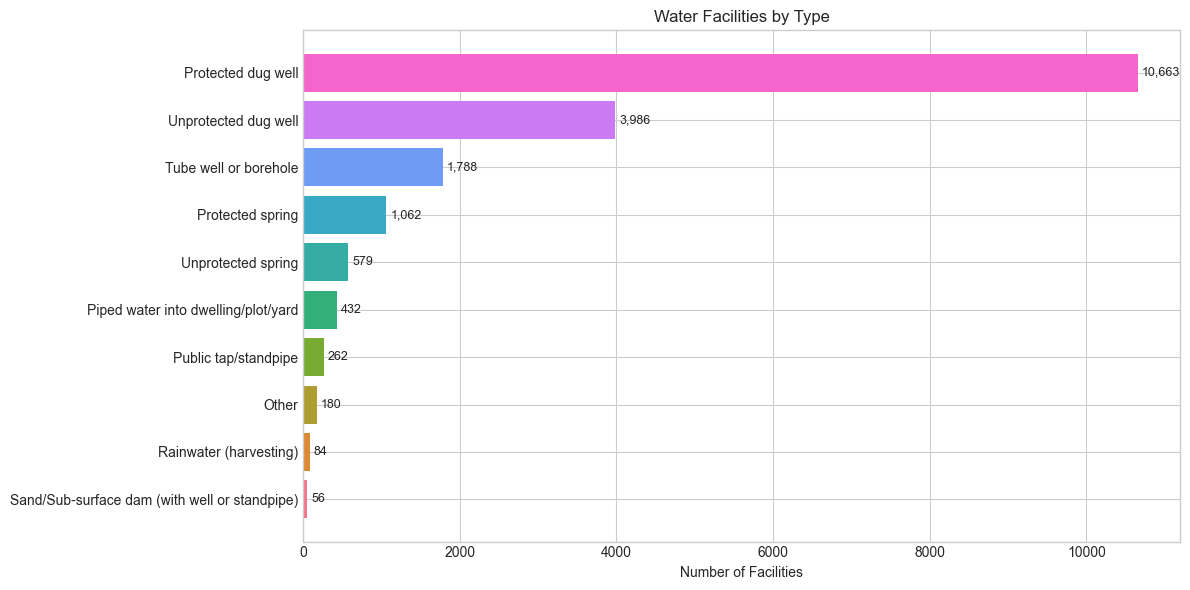

In [22]:
# Visualize water point types
df_types = pd.DataFrame(list(type_counts.items()), columns=['Type', 'Count'])
df_types = df_types.sort_values('Count', ascending=True)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(df_types['Type'], df_types['Count'], color=sns.color_palette("husl", len(df_types)))
ax.set_xlabel('Number of Facilities')
ax.set_title('Water Facilities by Type')

# Add count labels
for bar, count in zip(bars, df_types['Count']):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, 
            f'{count:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### 3.2 County Distribution

In [23]:
# Get sample to identify counties
data = get_all_facilities(filters={}, batch_size=500, max_records=5000)
df = to_dataframe(data)

print(f"Sample size: {len(df)} records")

Fetching 5000 of 19210 records...
  Fetched 5000 records total
Sample size: 5000 records


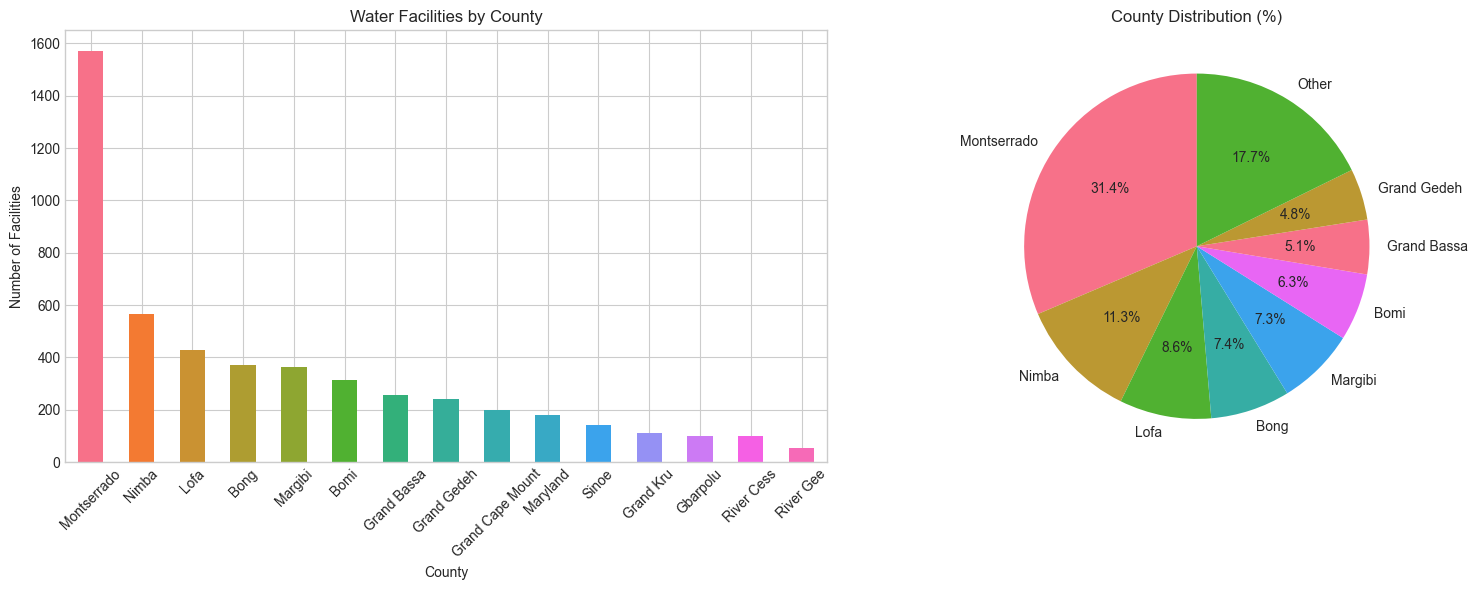

In [24]:
# County distribution
if 'location_county' in df.columns:
    county_counts = df['location_county'].value_counts()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart
    ax1 = axes[0]
    county_counts.plot(kind='bar', ax=ax1, color=sns.color_palette("husl", len(county_counts)))
    ax1.set_xlabel('County')
    ax1.set_ylabel('Number of Facilities')
    ax1.set_title('Water Facilities by County')
    ax1.tick_params(axis='x', rotation=45)
    
    # Pie chart
    ax2 = axes[1]
    top_counties = county_counts.head(8)
    other_count = county_counts[8:].sum() if len(county_counts) > 8 else 0
    if other_count > 0:
        top_counties['Other'] = other_count
    top_counties.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
    ax2.set_ylabel('')
    ax2.set_title('County Distribution (%)')
    
    plt.tight_layout()
    plt.show()

### 3.3 Extraction Type Analysis

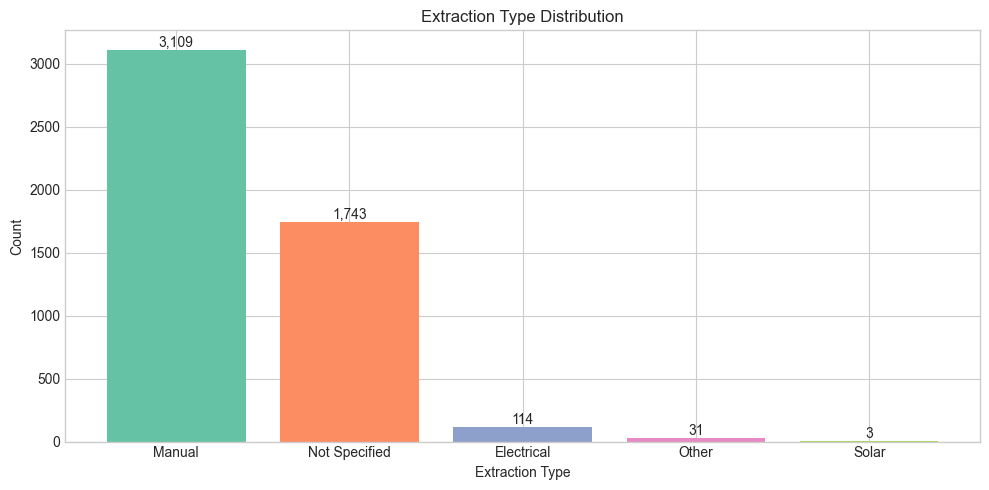

In [25]:
if 'extractionType' in df.columns:
    extraction_counts = df['extractionType'].fillna('Not Specified').value_counts()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = sns.color_palette("Set2", len(extraction_counts))
    bars = ax.bar(extraction_counts.index, extraction_counts.values, color=colors)
    ax.set_xlabel('Extraction Type')
    ax.set_ylabel('Count')
    ax.set_title('Extraction Type Distribution')
    
    # Add count labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

### 3.4 Pump Type Distribution

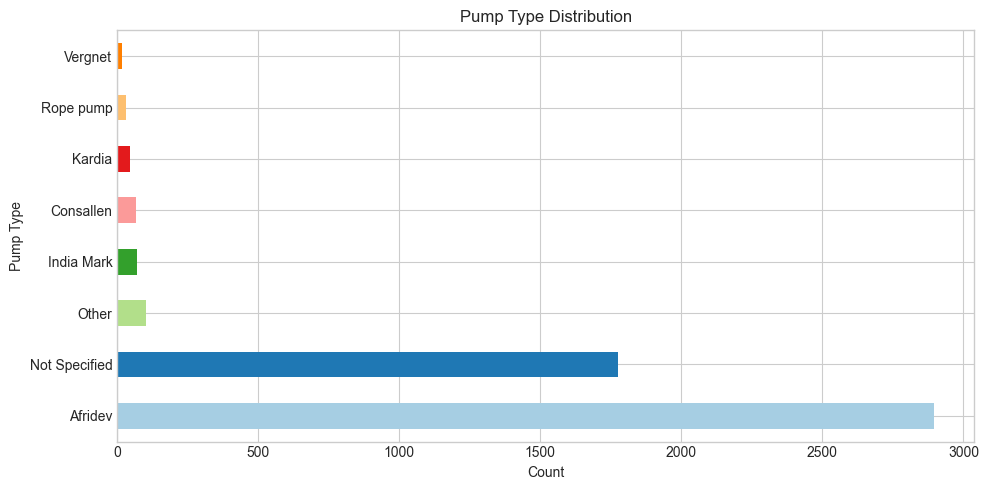

In [26]:
if 'pumpType' in df.columns:
    pump_counts = df['pumpType'].fillna('Not Specified').value_counts()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = sns.color_palette("Paired", len(pump_counts))
    pump_counts.plot(kind='barh', ax=ax, color=colors)
    ax.set_xlabel('Count')
    ax.set_ylabel('Pump Type')
    ax.set_title('Pump Type Distribution')
    
    plt.tight_layout()
    plt.show()

### 3.5 Installer vs Owner Analysis

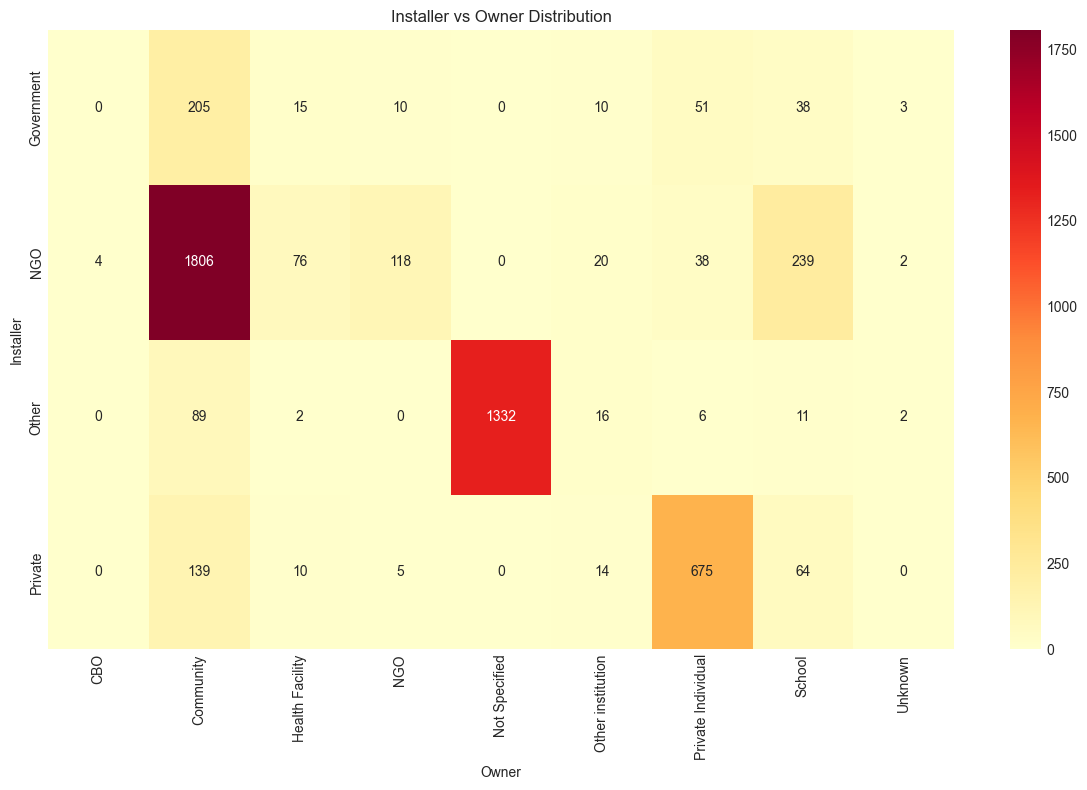

In [27]:
if 'installer' in df.columns and 'owner' in df.columns:
    # Create cross-tabulation
    cross_tab = pd.crosstab(
        df['installer'].fillna('Not Specified'),
        df['owner'].fillna('Not Specified')
    )
    
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
    ax.set_title('Installer vs Owner Distribution')
    ax.set_xlabel('Owner')
    ax.set_ylabel('Installer')
    
    plt.tight_layout()
    plt.show()

### 3.6 Elevation Distribution

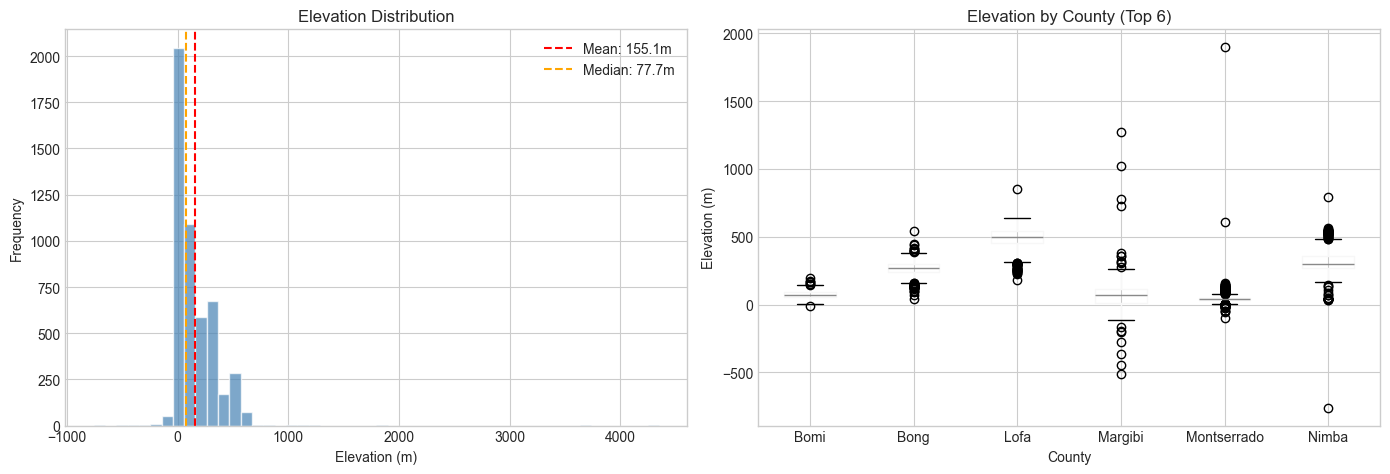

In [28]:
if 'location_coordinates.elevation' in df.columns:
    elevation_data = df['location_coordinates.elevation'].dropna()
    
    if len(elevation_data) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Histogram
        ax1 = axes[0]
        ax1.hist(elevation_data, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
        ax1.axvline(elevation_data.mean(), color='red', linestyle='--', label=f'Mean: {elevation_data.mean():.1f}m')
        ax1.axvline(elevation_data.median(), color='orange', linestyle='--', label=f'Median: {elevation_data.median():.1f}m')
        ax1.set_xlabel('Elevation (m)')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Elevation Distribution')
        ax1.legend()
        
        # Box plot by county (top 6)
        ax2 = axes[1]
        top_counties = df['location_county'].value_counts().head(6).index.tolist()
        df_subset = df[df['location_county'].isin(top_counties)].copy()
        df_subset = df_subset.dropna(subset=['location_coordinates.elevation'])
        
        if len(df_subset) > 0:
            df_subset.boxplot(column='location_coordinates.elevation', by='location_county', ax=ax2)
            ax2.set_xlabel('County')
            ax2.set_ylabel('Elevation (m)')
            ax2.set_title('Elevation by County (Top 6)')
            plt.suptitle('')
        
        plt.tight_layout()
        plt.show()

### 3.7 Geographic Scatter Plot

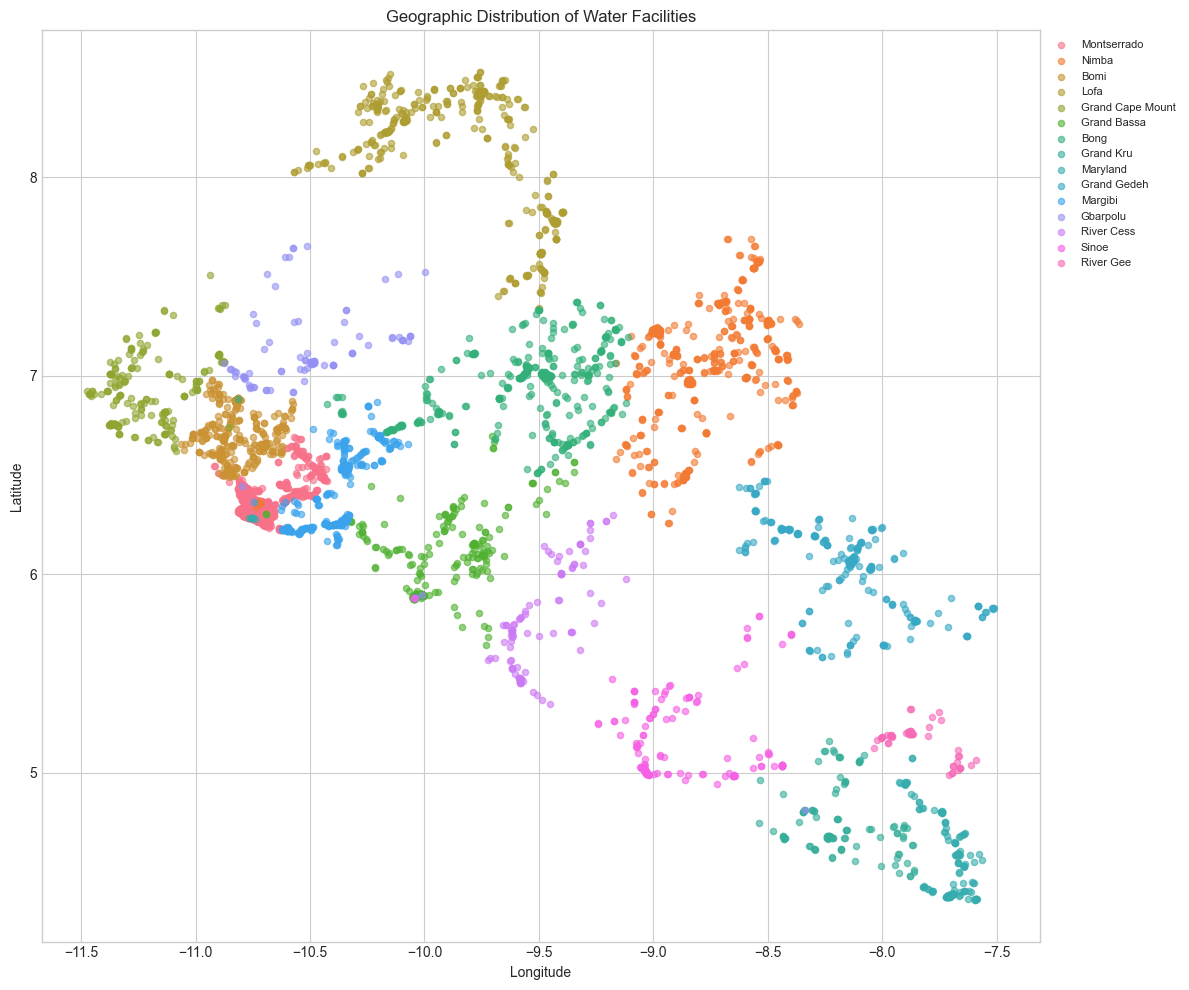

In [29]:
if 'location_coordinates.lat' in df.columns and 'location_coordinates.lon' in df.columns:
    geo_data = df.dropna(subset=['location_coordinates.lat', 'location_coordinates.lon']).copy()
    
    if len(geo_data) > 0:
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Color by county
        counties = geo_data['location_county'].unique()
        colors = dict(zip(counties, sns.color_palette("husl", len(counties))))
        
        for county in counties:
            subset = geo_data[geo_data['location_county'] == county]
            ax.scatter(
                subset['location_coordinates.lon'],
                subset['location_coordinates.lat'],
                c=[colors[county]],
                label=county,
                alpha=0.6,
                s=20
            )
        
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Geographic Distribution of Water Facilities')
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
        
        plt.tight_layout()
        plt.show()

### 3.8 Water Point Type by County Stacked Bar

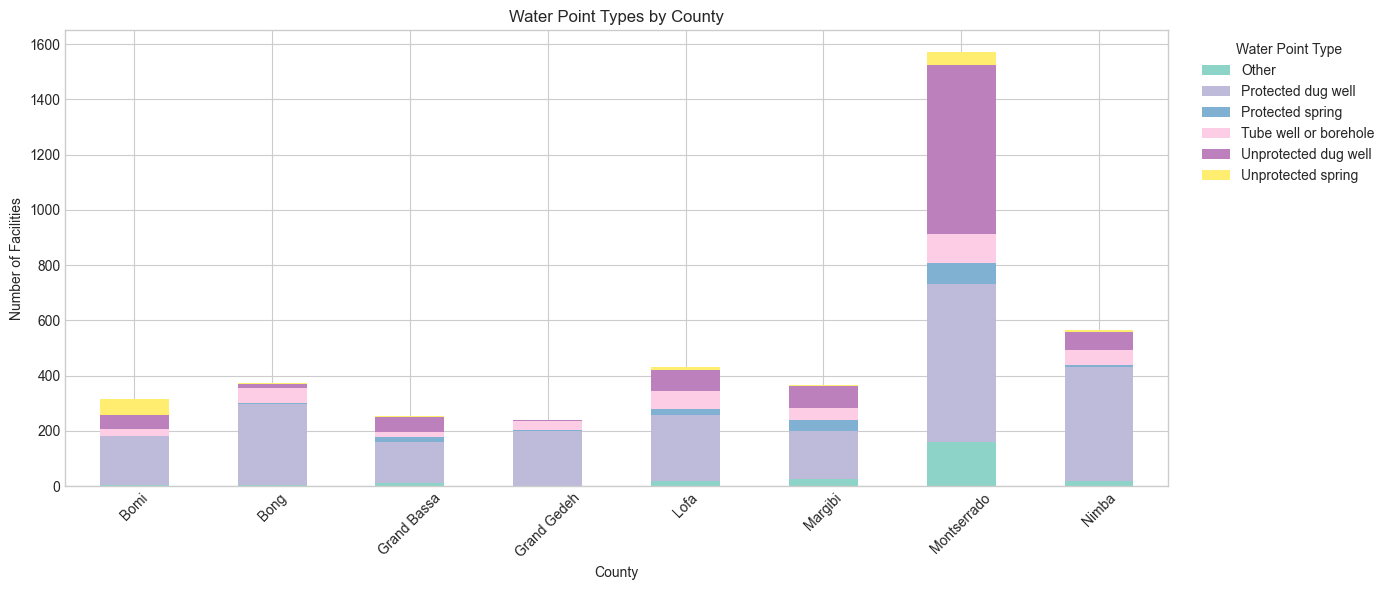

In [30]:
if 'location_county' in df.columns and 'waterPointType' in df.columns:
    # Get top 8 counties and top 5 water point types
    top_counties = df['location_county'].value_counts().head(8).index.tolist()
    top_types = df['waterPointType'].value_counts().head(5).index.tolist()
    
    df_filtered = df[df['location_county'].isin(top_counties)].copy()
    df_filtered['waterPointType'] = df_filtered['waterPointType'].apply(
        lambda x: x if x in top_types else 'Other'
    )
    
    pivot = df_filtered.pivot_table(
        index='location_county',
        columns='waterPointType',
        aggfunc='size',
        fill_value=0
    )
    
    fig, ax = plt.subplots(figsize=(14, 6))
    pivot.plot(kind='bar', stacked=True, ax=ax, colormap='Set3')
    ax.set_xlabel('County')
    ax.set_ylabel('Number of Facilities')
    ax.set_title('Water Point Types by County')
    ax.legend(title='Water Point Type', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

## 4. Advanced Filter Patterns

### 4.1 Geospatial Bounding Box Filter

In [31]:
# Define a bounding box (example: central Liberia region)
bbox = {
    "min_lat": 6.0,
    "max_lat": 7.5,
    "min_lon": -10.0,
    "max_lon": -8.5
}

result = search_facilities(
    filters={
        "location.coordinates.lat": {"gte": bbox['min_lat'], "lte": bbox['max_lat']},
        "location.coordinates.lon": {"gte": bbox['min_lon'], "lte": bbox['max_lon']}
    },
    limit=100
)

print(f"Facilities in bounding box: {result['totalCount']}")
print(f"Box: lat [{bbox['min_lat']}, {bbox['max_lat']}], lon [{bbox['min_lon']}, {bbox['max_lon']}]")

Facilities in bounding box: 5332
Box: lat [6.0, 7.5], lon [-10.0, -8.5]


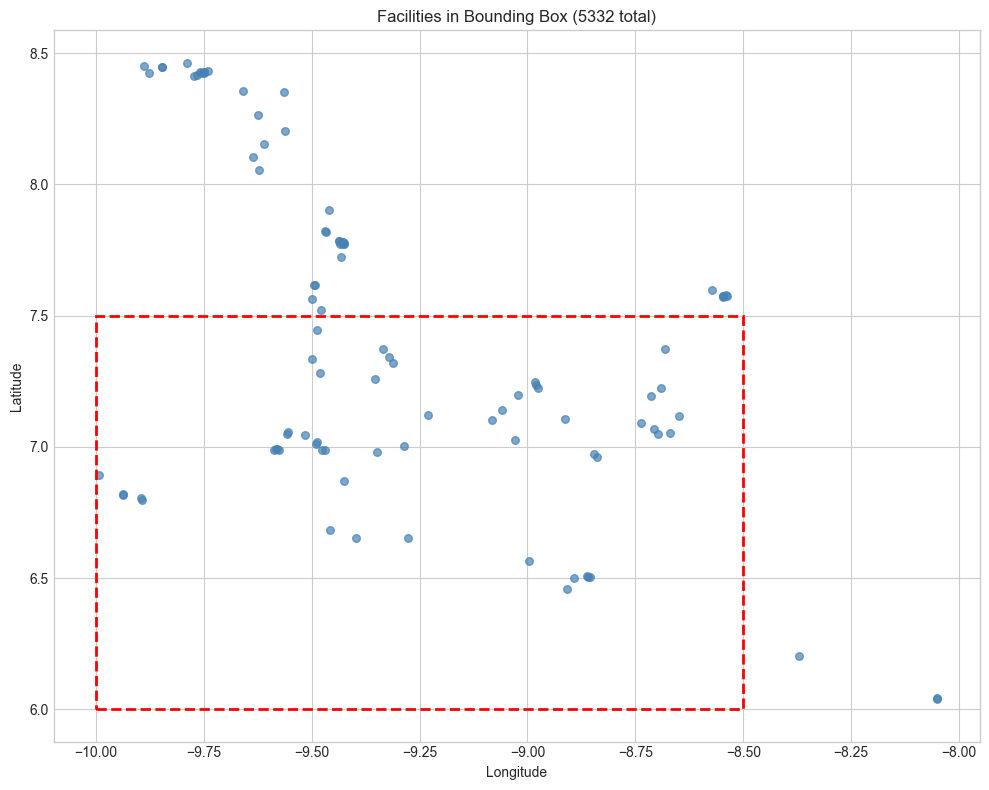

In [32]:
# Visualize bounding box query
if result and result['data']:
    df_bbox = to_dataframe(result['data'])
    
    if 'location_coordinates.lat' in df_bbox.columns:
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Plot points
        scatter = ax.scatter(
            df_bbox['location_coordinates.lon'],
            df_bbox['location_coordinates.lat'],
            c='steelblue',
            alpha=0.7,
            s=30
        )
        
        # Draw bounding box
        from matplotlib.patches import Rectangle
        rect = Rectangle(
            (bbox['min_lon'], bbox['min_lat']),
            bbox['max_lon'] - bbox['min_lon'],
            bbox['max_lat'] - bbox['min_lat'],
            linewidth=2,
            edgecolor='red',
            facecolor='none',
            linestyle='--'
        )
        ax.add_patch(rect)
        
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'Facilities in Bounding Box ({result["totalCount"]} total)')
        
        plt.tight_layout()
        plt.show()

### 4.2 Complex Combined Filter

In [33]:
# Find electrical boreholes or protected springs in high elevation areas
complex_filter = {
    "waterPointType": {"or": ["Tube well or borehole", "Protected spring"]},
    "extractionType": {"eq": "Electrical"},
    "location.coordinates.elevation": {"gt": 300},
    "owner": {"neq": "Unknown"}
}

result = search_facilities(filters=complex_filter, limit=20)

print(f"Electrical boreholes/springs at high elevation with known owner: {result['totalCount']}")
df = to_dataframe(result['data'])
if not df.empty:
    cols = ['wfId', 'waterPointType', 'extractionType', 'owner', 'location_county']
    cols = [c for c in cols if c in df.columns]
    display(df[cols].head(10))

Electrical boreholes/springs at high elevation with known owner: 137


,wfId,waterPointType,extractionType,owner,location_county
0,WF-NIM-GAR-TWB-47FA95,Tube well or borehole,Electrical,NGO,Nimba
1,WF-NIM-DOE-TWB-A9F589,Tube well or borehole,Electrical,Health Facility,Nimba
2,WF-BON-KPA-TWB-CFD8C7,Tube well or borehole,Electrical,School,Bong
3,WF-BON-ZOT-TWB-A1E2B0,Tube well or borehole,Electrical,Community,Bong
4,WF-LOF-SAL-TWB-385D10,Tube well or borehole,Electrical,Community,Lofa
5,WF-BON-ZOT-TWB-4F3ADA,Tube well or borehole,Electrical,Community,Bong
6,WF-NIM-YAR-TWB-5101F0,Tube well or borehole,Electrical,Community,Nimba
7,WF-LOF-KOL-TWB-F86447,Tube well or borehole,Electrical,Community,Lofa
8,WF-LOF-ZOR-TWB-143994,Tube well or borehole,Electrical,School,Lofa
9,WF-LOF-ZOR-TWB-C90170,Tube well or borehole,Electrical,Community,Lofa


## 5. Filter Query Builder

A helper function to build complex Elasticsearch queries programmatically.

In [34]:
class FilterBuilder:
    """Build Elasticsearch-compatible filter queries."""
    
    def __init__(self):
        self.filters = {}
    
    def equals(self, field, value):
        """Add equality filter."""
        self.filters[field] = {"eq": value}
        return self
    
    def not_equals(self, field, value):
        """Add not-equal filter."""
        self.filters[field] = {"neq": value}
        return self
    
    def in_list(self, field, values):
        """Add OR filter for multiple values."""
        self.filters[field] = {"or": values}
        return self
    
    def range(self, field, gte=None, lte=None, gt=None, lt=None):
        """Add range filter."""
        range_filter = {}
        if gte is not None:
            range_filter["gte"] = gte
        if lte is not None:
            range_filter["lte"] = lte
        if gt is not None:
            range_filter["gt"] = gt
        if lt is not None:
            range_filter["lt"] = lt
        self.filters[field] = range_filter
        return self
    
    def contains(self, field, text):
        """Add text contains filter."""
        self.filters[field] = {"contains": text}
        return self
    
    def build(self):
        """Return the filter dictionary."""
        return self.filters.copy()
    
    def clear(self):
        """Clear all filters."""
        self.filters = {}
        return self


# Example usage
fb = FilterBuilder()
query = (fb
    .in_list("location.county", ["Nimba", "Bong"])
    .equals("waterPointType", "Tube well or borehole")
    .range("location.coordinates.elevation", gte=200, lte=500)
    .build()
)

print("Built query:")
print(json.dumps(query, indent=2))

result = search_facilities(filters=query, limit=10)
print(f"\nMatching facilities: {result['totalCount']}")

Built query:
{
  "location.county": {
    "or": [
      "Nimba",
      "Bong"
    ]
  },
  "waterPointType": {
    "eq": "Tube well or borehole"
  },
  "location.coordinates.elevation": {
    "gte": 200,
    "lte": 500
  }
}

Matching facilities: 361


## 6. Summary Statistics Dashboard

In [35]:
def generate_summary_stats():
    """Generate summary statistics from the registry."""
    stats = {}
    
    # Total count
    result = search_facilities(filters={}, limit=1)
    stats['total'] = result['totalCount'] if result else 0
    
    # Count by extraction type
    extraction_types = ["Manual", "Electrical", "Solar", "Other"]
    stats['by_extraction'] = {}
    for et in extraction_types:
        result = search_facilities(filters={"extractionType": {"eq": et}}, limit=1)
        stats['by_extraction'][et] = result['totalCount'] if result else 0
    
    # Count with depth info (using depthMetres > 0 because hasDepthInfo boolean filter doesn't work)
    # Note: hasDepthInfo=True returns 0 due to ES indexing issue, but depthMetres > 0 works
    result = search_facilities(filters={"depthMetres": {"gt": 0}}, limit=1)
    stats['with_depth'] = result['totalCount'] if result else 0
    
    # Count with coordinates
    result = search_facilities(filters={"location.coordinates.lat": {"gt": -90}}, limit=1)
    stats['with_coords'] = result['totalCount'] if result else 0
    
    return stats

print("Generating summary statistics...")
summary = generate_summary_stats()

print(f"\n{'='*50}")
print("REGISTRY SUMMARY")
print(f"{'='*50}")
print(f"Total Facilities: {summary['total']:,}")
print(f"With Coordinates: {summary['with_coords']:,} ({summary['with_coords']/summary['total']*100:.1f}%)")
print(f"With Depth Info: {summary['with_depth']:,} ({summary['with_depth']/summary['total']*100:.1f}%)")
print(f"\nBy Extraction Type:")
for et, count in summary['by_extraction'].items():
    print(f"  {et}: {count:,}")

Generating summary statistics...

REGISTRY SUMMARY
Total Facilities: 19,210
With Coordinates: 19,210 (100.0%)
With Depth Info: 3,663 (19.1%)

By Extraction Type:
  Manual: 12,141
  Electrical: 508
  Solar: 25
  Other: 97


## 7. Filter Reference Card

| Filter Type | Syntax | Example |
|-------------|--------|--------|
| Equals | `{"field": {"eq": "value"}}` | `{"county": {"eq": "Nimba"}}` |
| Not Equals | `{"field": {"neq": "value"}}` | `{"owner": {"neq": "Unknown"}}` |
| Greater Than | `{"field": {"gt": value}}` | `{"depth": {"gt": 50}}` |
| Greater/Equal | `{"field": {"gte": value}}` | `{"elevation": {"gte": 200}}` |
| Less Than | `{"field": {"lt": value}}` | `{"depth": {"lt": 100}}` |
| Less/Equal | `{"field": {"lte": value}}` | `{"elevation": {"lte": 500}}` |
| Contains | `{"field": {"contains": "text"}}` | `{"community": {"contains": "Town"}}` |
| OR (any of) | `{"field": {"or": ["a", "b"]}}` | `{"county": {"or": ["Nimba", "Bong"]}}` |
| Range | `{"field": {"gte": min, "lte": max}}` | `{"elevation": {"gte": 200, "lte": 400}}` |
| Nested | `{"parent.child": {"eq": "value"}}` | `{"location.county": {"eq": "Nimba"}}` |

**Notes:**
- Multiple filters are combined with AND logic
- Nested object fields use dot notation (e.g., `location.county`)
- All filters are passed in the `filters` object of the search request

In [36]:
print(f"Token status: {'Valid' if not token_manager.is_expired() else 'Expired'}")
print(f"Time until expiry: {token_manager.time_until_expiry():.0f} seconds")

Token status: Valid
Time until expiry: 138 seconds
